In [1]:
import math
import sklearn
import skimage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce
import glob

In [2]:
#ims = [plt.imread(path) for path in glob.glob("C:/Users/rwfbl/Tiffs for PCA degridding/*.tif")]
horizontal_number = 11 
vertical_number = 19

In [3]:
ims_downscaled = []
for i in range(len(ims)):
    #print(i)
    ims_downscaled.append((skimage.transform.downscale_local_mean(ims[i], (4,4))).flatten())
ims_downscaled_array = np.array(ims_downscaled)    


    

NameError: name 'ims' is not defined

In [7]:
ims = 0

In [6]:

for i in range(vertical_number):
    for j in range(horizontal_number):
        print(i+1,j+1)
        pos_in_list = (horizontal_number*i)+j
        to_save = ims_downscaled[pos_in_list].reshape(512,768)
        to_save = to_save.astype(np.uint16)
        to_save = Image.fromarray(to_save)
        if i>=9 and j>=9:
            thing = 1
            to_save.save('downscaled_'+str(i+1)+'_'+str(j+1)+'.png')
        elif i<9 and j<9:
            thing = 1
            to_save.save('downscaled_0'+str(i+1)+'_0'+str(j+1)+'.png')
        elif i<9:
            thing = 1
            to_save.save('downscaled_0'+str(i+1)+'_'+str(j+1)+'.png')
        elif j <9:
            thing = 1
            to_save.save('downscaled_'+str(i+1)+'_0'+str(j+1)+'.png')
ims_downscaled = 0
ims_downscaled_array = 0

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
15 11
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
18 11
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
19 11


In [8]:


ims_downscaled_array = np.array([plt.imread(path) for path in glob.glob("C:/Users/rwfbl/downscaled_pngs/*.png")])*256*256

In [9]:
inboard_tile_numbers = [] #Numbers for the tiles which are considered "inboard", those which are at least 90% sample
black_tile_numbers = [] #Numbers for the tiles which are considered "black", those which are at least 90% empty space without plag
edge_tile_numbers = [] #Numbers for the tiles which are considered "edges", those which are between 
black_masks = []
bright_masks = []
plag_masks = []

black_threshold = 105
bright_threshold = 133

for i in range(len(ims_downscaled_array)):
    black_masks.append(ims_downscaled_array[i]<black_threshold)
    bright_masks.append(ims_downscaled_array[i]>bright_threshold)
    plag_masks.append((black_threshold<ims_downscaled_array[i]) & (ims_downscaled_array[i]<bright_threshold))
    if np.mean(black_masks[i]) > 0.9:
        black_tile_numbers.append(i)
    elif np.mean(black_masks[i]) <0.1:
        inboard_tile_numbers.append(i)
    else:
        edge_tile_numbers.append(i)
    
black_masks = np.array(black_masks)
bright_masks = np.array(bright_masks)
plag_masks = np.array(plag_masks)

In [10]:
#Take the inboard tiles and replace their dark areas with random values from their distribution of other values
inboard_downscaled_masked = []
for i in inboard_tile_numbers:
    sample_values = ims_downscaled_array[i]*plag_masks[i] #Find all pixel values which are neither too bright nor too dark to be plag
    sample_mean = np.mean(sample_values[sample_values>1])
    sample_deviation = np.std(sample_values[sample_values>1])
    fitting_array = (1-plag_masks[i])*np.random.normal(sample_mean, sample_deviation, ims_downscaled_array[i].shape) #Make an array 
    
    inboard_downscaled_masked.append((fitting_array+sample_values).flatten())
    #print(sample_mean, sample_deviation)
inboard_downscaled_masked = np.array(inboard_downscaled_masked)

7.714940325221434


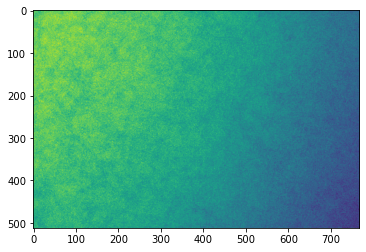

In [31]:
plt.imshow(np.mean(inboard_downscaled_masked,0).reshape(512,768))
print(np.max(np.mean(inboard_downscaled_masked,0)) - np.min(np.mean(inboard_downscaled_masked,0)))

In [12]:
#Do the primary/first order de-gridding

#This is the version of the processing which only took into account the mean of inboard tiles

mean_contrast = np.mean(inboard_downscaled_masked,0).reshape(512,768) - np.mean(np.mean(inboard_downscaled_masked,0))
mean_subtracted = ims_downscaled_array-mean_contrast

In [17]:
#Take the edge tiles and replace their dark areas with random values from their distribution of other values
edge_downscaled_masked = []
for i in edge_tile_numbers:
    sample_values = mean_subtracted[i]*plag_masks[i] #Find all pixel values which are neither too bright nor too dark to be plag
    sample_mean = np.mean(sample_values[sample_values>1])
    sample_deviation = np.std(sample_values[sample_values>1])
    fitting_array = (1-plag_masks[i])*np.random.normal(sample_mean, sample_deviation, ims_downscaled_array[i].shape) #Make an array 
    
    edge_downscaled_masked.append((fitting_array+sample_values).flatten())
    #print(sample_mean, sample_deviation)
edge_degridded_masked = np.array(edge_downscaled_masked)

In [18]:
#Take the inboard tiles and replace their dark areas with random values from their distribution of other values again
inboard_downscaled_remasked = []
for i in inboard_tile_numbers:
    sample_values = mean_subtracted[i]*plag_masks[i] #Find all pixel values which are neither too bright nor too dark to be plag
    sample_mean = np.mean(sample_values[sample_values>1])
    sample_deviation = np.std(sample_values[sample_values>1])
    fitting_array = (1-plag_masks[i])*np.random.normal(sample_mean, sample_deviation, ims_downscaled_array[i].shape) #Make an array 
    
    inboard_downscaled_remasked.append((fitting_array+sample_values).flatten())
    #print(sample_mean, sample_deviation)
inboard_degridded_remasked = np.array(inboard_downscaled_remasked)

6.637715641974353


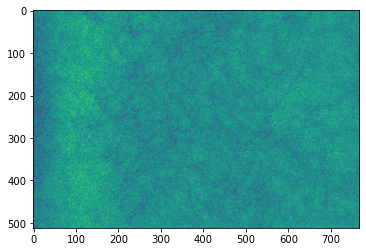

In [23]:
plt.imshow(np.mean(edge_degridded_masked,0).reshape(512,768))
print(np.max(np.mean(edge_degridded_masked,0)) - np.min(np.mean(edge_degridded_masked,0)))

2.0799984246506256


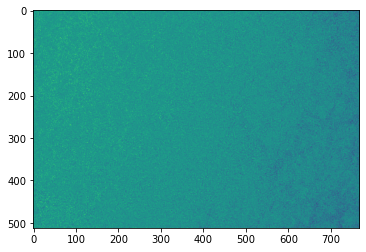

In [24]:
plt.imshow(np.mean(inboard_degridded_remasked,0).reshape(512,768))
print(np.max(np.mean(inboard_degridded_remasked,0)) - np.min(np.mean(inboard_degridded_remasked,0)))

In [25]:
#Do the second order de-gridding

#This is the version of the processing which only took into account the mean of inboard tiles

mean_contrast = np.mean(inboard_downscaled_remasked,0).reshape(512,768) - np.mean(np.mean(inboard_downscaled_remasked,0))
double_degridded = mean_subtracted-mean_contrast

In [26]:
#Take the inboard tiles and replace their dark areas with random values from their distribution of other values again
inboard_downscaled_reremasked = []
for i in inboard_tile_numbers:
    sample_values = double_degridded[i]*plag_masks[i] #Find all pixel values which are neither too bright nor too dark to be plag
    sample_mean = np.mean(sample_values[sample_values>1])
    sample_deviation = np.std(sample_values[sample_values>1])
    fitting_array = (1-plag_masks[i])*np.random.normal(sample_mean, sample_deviation, ims_downscaled_array[i].shape) #Make an array 
    
    inboard_downscaled_reremasked.append((fitting_array+sample_values).flatten())
    #print(sample_mean, sample_deviation)
inboard_degridded_reremasked = np.array(inboard_downscaled_reremasked)

1.655087785184051


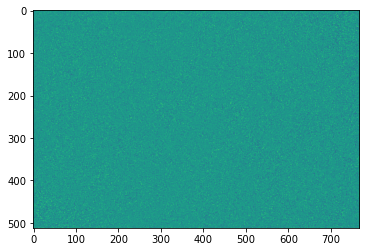

In [27]:
plt.imshow(np.mean(inboard_degridded_reremasked,0).reshape(512,768))
print(np.max(np.mean(inboard_degridded_reremasked,0)) - np.min(np.mean(inboard_degridded_reremasked,0)))

In [32]:
thing = np.mean(inboard_degridded_reremasked,0).reshape(512,768)
print(np.mean(thing[:, 0:100]))
print(np.mean(thing[:, 650:750]))
print(np.max(thing[:, 0:100]))
print(np.max(thing[:, 650:750]))

120.34473202029774
120.33231446800784
121.08688245590899
121.06879782660516


In [33]:
#Take the edge tiles and replace their dark areas with random values from their distribution of other values again
edge_downscaled_remasked = []
for i in edge_tile_numbers:
    sample_values = double_degridded[i]*plag_masks[i] #Find all pixel values which are neither too bright nor too dark to be plag
    sample_mean = np.mean(sample_values[sample_values>1])
    sample_deviation = np.std(sample_values[sample_values>1])
    fitting_array = (1-plag_masks[i])*np.random.normal(sample_mean, sample_deviation, ims_downscaled_array[i].shape) #Make an array 
    
    edge_downscaled_remasked.append((fitting_array+sample_values).flatten())
    #print(sample_mean, sample_deviation)
edge_degridded_remasked = np.array(edge_downscaled_remasked)

6.665639708275492


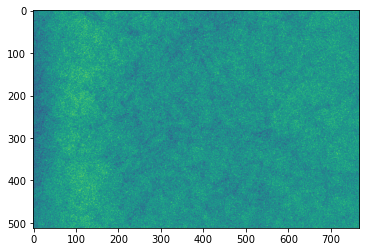

In [34]:
plt.imshow(np.mean(edge_degridded_remasked,0).reshape(512,768))
print(np.max(np.mean(edge_degridded_remasked,0)) - np.min(np.mean(edge_degridded_remasked,0)))

In [36]:
#Do the removal of the edge feature

mean_contrast = np.mean(edge_degridded_remasked,0).reshape(512,768) - np.mean(np.mean(edge_degridded_remasked,0))
double_degridded_barred = double_degridded
double_degridded_barred[edge_tile_numbers] = double_degridded[edge_tile_numbers] - mean_contrast

In [37]:
#Take the edge tiles and replace their dark areas with random values from their distribution of other values again, again
edge_downscaled_reremasked = []
for i in edge_tile_numbers:
    sample_values = double_degridded_barred[i]*plag_masks[i] #Find all pixel values which are neither too bright nor too dark to be plag
    sample_mean = np.mean(sample_values[sample_values>1])
    sample_deviation = np.std(sample_values[sample_values>1])
    fitting_array = (1-plag_masks[i])*np.random.normal(sample_mean, sample_deviation, ims_downscaled_array[i].shape) #Make an array 
    
    edge_downscaled_reremasked.append((fitting_array+sample_values).flatten())
    #print(sample_mean, sample_deviation)
edge_degridded_reremasked = np.array(edge_downscaled_reremasked)

5.756634997501919


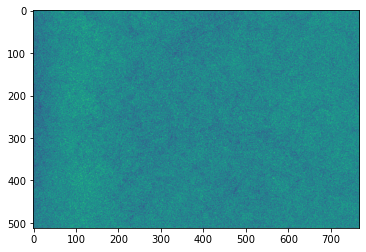

In [38]:
plt.imshow(np.mean(edge_degridded_reremasked,0).reshape(512,768))
print(np.max(np.mean(edge_degridded_reremasked,0)) - np.min(np.mean(edge_degridded_reremasked,0)))

In [39]:
#Do the removal of the edge feature

mean_contrast = np.mean(edge_degridded_reremasked,0).reshape(512,768) - np.mean(np.mean(edge_degridded_reremasked,0))
double_degridded_double_barred = double_degridded_barred
double_degridded_double_barred[edge_tile_numbers] = double_degridded_barred[edge_tile_numbers] - mean_contrast

In [40]:
#Take the edge tiles and replace their dark areas with random values from their distribution of other values again, again
edge_downscaled_rereremasked = []
for i in edge_tile_numbers:
    sample_values = double_degridded_double_barred[i]*plag_masks[i] #Find all pixel values which are neither too bright nor too dark to be plag
    sample_mean = np.mean(sample_values[sample_values>1])
    sample_deviation = np.std(sample_values[sample_values>1])
    fitting_array = (1-plag_masks[i])*np.random.normal(sample_mean, sample_deviation, ims_downscaled_array[i].shape) #Make an array 
    
    edge_downscaled_rereremasked.append((fitting_array+sample_values).flatten())
    #print(sample_mean, sample_deviation)
edge_degridded_rereremasked = np.array(edge_downscaled_rereremasked)

5.161623870524394


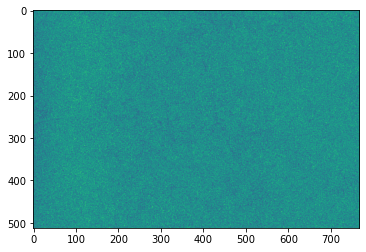

In [41]:
plt.imshow(np.mean(edge_degridded_rereremasked,0).reshape(512,768))
print(np.max(np.mean(edge_degridded_rereremasked,0)) - np.min(np.mean(edge_degridded_rereremasked,0)))

In [42]:
#Do the removal of the edge feature

mean_contrast = np.mean(edge_degridded_reremasked,0).reshape(512,768) - np.mean(np.mean(edge_degridded_reremasked,0))
double_degridded_triple_barred = double_degridded_double_barred
double_degridded_triple_barred[edge_tile_numbers] = double_degridded_double_barred[edge_tile_numbers] - mean_contrast

In [43]:
#Take the edge tiles and replace their dark areas with random values from their distribution of other values again, again
edge_downscaled_rerereremasked = []
for i in edge_tile_numbers:
    sample_values = double_degridded_triple_barred[i]*plag_masks[i] #Find all pixel values which are neither too bright nor too dark to be plag
    sample_mean = np.mean(sample_values[sample_values>1])
    sample_deviation = np.std(sample_values[sample_values>1])
    fitting_array = (1-plag_masks[i])*np.random.normal(sample_mean, sample_deviation, ims_downscaled_array[i].shape) #Make an array 
    
    edge_downscaled_rerereremasked.append((fitting_array+sample_values).flatten())
    #print(sample_mean, sample_deviation)
edge_degridded_rerereremasked = np.array(edge_downscaled_rerereremasked)

5.161623870524394


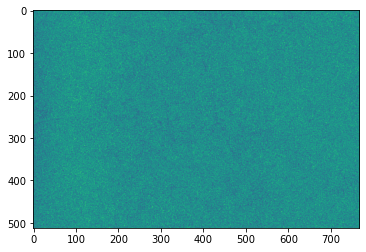

In [44]:
plt.imshow(np.mean(edge_degridded_rereremasked,0).reshape(512,768))
print(np.max(np.mean(edge_degridded_rereremasked,0)) - np.min(np.mean(edge_degridded_rereremasked,0)))

(119, 393216)
121.32510827275621
119.0063568987517
123.27019389216233
120.94981210186059


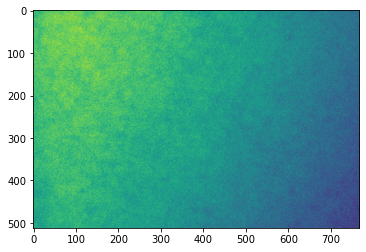

In [33]:
inboard_and_edge_downscaled_masked = np.append(edge_downscaled_masked, inboard_downscaled_masked, 0)
print(inboard_and_edge_downscaled_masked.shape)
plt.imshow(np.mean(inboard_and_edge_downscaled_masked,0).reshape(512,768))
thing = np.mean(inboard_and_edge_downscaled_masked,0).reshape(512,768)
print(np.mean(thing[:, 0:100]))
print(np.mean(thing[:, 650:750]))
print(np.max(thing[:, 0:100]))
print(np.max(thing[:, 650:750]))

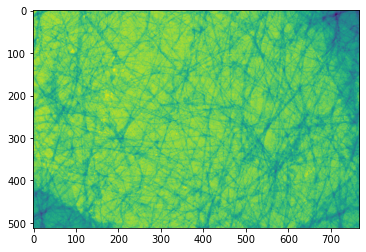

In [71]:
plt.imshow(np.mean(mean_subtracted[inboard_tile_numbers], 0))

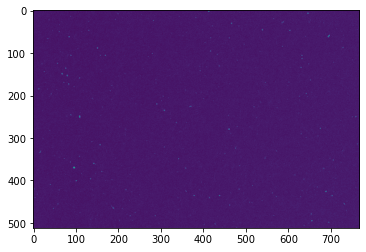

In [67]:
plt.imshow(mean_subtracted[28].reshape(512,768))

120.34755039181505
120.34755039181505
120.34755039181506
120.34755039181503


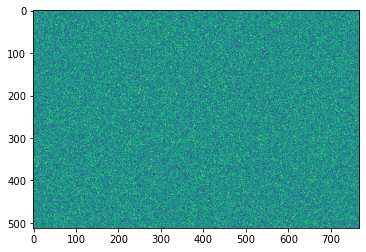

In [39]:
gradient_check = np.mean(mean_subtracted, 0).reshape(512,768)
print(np.mean(gradient_check[0:100, :]))
print(np.mean(gradient_check[400:500, :]))
print(np.mean(gradient_check[:, 0:100]))
print(np.mean(gradient_check[:, 650:750]))
plt.imshow(gradient_check)

In [28]:
np.max(gradient_check)-np.min(gradient_check)

8.100187187665142e-13

In [36]:
are_you_sure = 0
if are_you_sure == 1:
    full_set = pd.Series(ims_downscaled_array.flatten())
    black_example = pd.Series(ims_downscaled[1].flatten())
    plain_example = pd.Series(ims_downscaled[36].flatten())
    bright_example = pd.Series(ims_downscaled[3].flatten())

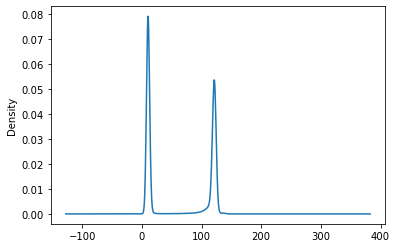

In [35]:
#ax = full_set.plot.kde()

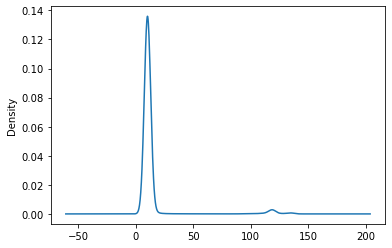

In [27]:
#ax = black_example.plot.kde()

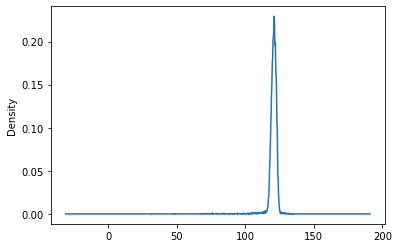

In [43]:
ax = plain_example.plot.kde(bw_method = 0.01)

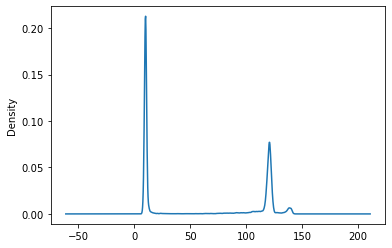

In [42]:
ax = bright_example.plot.kde(bw_method = 0.01)

In [69]:
pca = PCA(n_components=15)
pca.fit(inboard_downscaled_masked)

PCA(n_components=15)

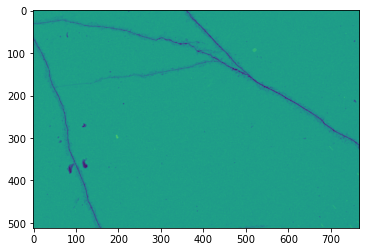

In [59]:
plt.imshow(black_mask_reapplied[35])

In [45]:
#This reapplies the black and bright pixels

new_processing_approach_tiffs = []
black_mask_reapplied = []

for i in range(len(ims_downscaled_array)):
    mean_subtracted_masked = np.zeros(double_degridded_triple_barred[i].shape)
    mean_subtracted_masked[black_masks[i] == False] = double_degridded_triple_barred[i][black_masks[i] == False]
    mean_subtracted_masked[black_masks[i] == True] = double_degridded_triple_barred[i][black_masks[i] == True]
    black_mask_reapplied.append(mean_subtracted_masked) 

In [85]:
#This is the version of the processing which only took into account the mean of inboard tiles

new_processing_approach_tiffs = []
black_mask_reapplied = []

mean_contrast = pca.mean_.reshape(512,768) - np.mean(pca.mean_)
mean_subtracted = ims_downscaled_array-mean_contrast
for i in range(len(ims_downscaled_array)):
    mean_subtracted_masked = np.zeros(ims_downscaled_array[i].shape)
    mean_subtracted_masked[black_masks[i] == False] = mean_subtracted[i][black_masks[i] == False]
    mean_subtracted_masked[black_masks[i] == True] = ims_downscaled_array[i][black_masks[i] == True]
    black_mask_reapplied.append(mean_subtracted_masked) 
    
    

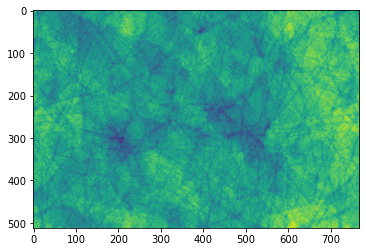

In [46]:
plt.imshow(np.mean(black_mask_reapplied, 0))

In [47]:
for i in range(vertical_number):
    for j in range(horizontal_number):
        print(i+1,j+1)
        pos_in_list = (horizontal_number*i)+j
        to_save = (black_mask_reapplied[pos_in_list].reshape(512,768))*256
        to_save = to_save.astype(np.uint16)
        to_save = Image.fromarray(to_save)
        if i>=9 and j>=9:
            thing = 1
            to_save.save('edge_sep_'+str(i+1)+'_'+str(j+1)+'.png')
        elif i<9 and j<9:
            thing = 1
            to_save.save('edge_sep_0'+str(i+1)+'_0'+str(j+1)+'.png')
        elif i<9:
            thing = 1
            to_save.save('edge_sep_0'+str(i+1)+'_'+str(j+1)+'.png')
        elif j <9:
            thing = 1
            to_save.save('edge_sep_'+str(i+1)+'_0'+str(j+1)+'.png')

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
15 11
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
18 11
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
19 11


In [94]:
black_mask_reapplied[2][black_mask_reapplied[2]<2]

array([1.00001526, 1.00001526, 0.        , 1.00001526, 1.00001526,
       1.00001526, 1.00001526, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.00001526, 0.        , 0.        , 0.        ,
       0.        , 1.00001526, 1.00001526, 0.        , 1.00001526,
       0.        , 0.        ])

In [90]:
mean_contrast

array([[ 0.53026364,  1.11104241,  0.32427321, ..., -1.93989774,
        -1.96168536, -2.70944632],
       [ 1.60681166,  1.57566516,  1.38076601, ..., -2.05584234,
        -2.52023872, -0.93525702],
       [ 1.85199079,  1.18669243,  1.62787371, ..., -1.63022845,
        -2.46950994, -2.20614094],
       ...,
       [ 0.64535616,  1.08841053,  0.30797554, ..., -2.90581924,
        -2.83925869, -2.56629106],
       [ 1.32227671,  0.42071294, -0.43277375, ..., -3.49533979,
        -3.21967747, -3.50990079],
       [ 0.61960167,  0.90103798,  0.49135408, ..., -3.35735072,
        -3.10276174, -3.9176746 ]])

In [7]:
#below_cutoff = [] #for old brightness fixing

In [8]:
#for i in range(len(ims_downscaled[0])):  #for old brightness fixing
#    if ims_downscaled[0][i]<15:
#        below_cutoff.append(ims_downscaled[0][i])

In [8]:
#below_cutoff

In [9]:
#(skimage.transform.downscale_local_mean(ims[1], (4,4))).flatten()

In [11]:
#ims_downscaled_array[13][0] = 255
#to_save = Image.fromarray(ims_downscaled_array[13].reshape(512,768))
#print(to_save)
#to_save.save('tiffnesstest.tif')

In [12]:
#does_imaging_break_it = Image.fromarray(ims_downscaled_array[14].reshape(512,768))
#does_imaging_break_it = np.array(does_imaging_break_it)
#does_imaging_break_it


In [13]:
#does_saving_break_it = Image.fromarray(ims_downscaled_array[14].reshape(512,768))
#does_saving_break_it.save('does_saving_break_it.tif')
#beep_boop = plt.imread('does_saving_break_it.tif')
#np.array(beep_boop)

In [14]:
print(np.mean(ims_downscaled_array[13]))
testing_thresholding = np.array(more_processed_tifs[12])
lower_threshold = 90 *256
upper_threshold = 140 *256
testing_thresholding[testing_thresholding>upper_threshold] = upper_threshold
testing_thresholding[testing_thresholding<lower_threshold] = lower_threshold
plt.imshow(testing_thresholding)
testing_thresholding = testing_thresholding.astype(np.uint16)
testing_thresholding = Image.fromarray(testing_thresholding)
#testing_thresholding.save('1_comps_removed_inboard.png')

120.00251213709514


NameError: name 'more_processed_tifs' is not defined

In [ ]:
testing_thresholding = np.array(more_processed_tifs[13])
testing_thresholding[testing_thresholding>upper_threshold] = upper_threshold
testing_thresholding[testing_thresholding<lower_threshold] = lower_threshold
plt.imshow(testing_thresholding)

In [ ]:
lower_threshold = 80 *256
upper_threshold = 120 *256
testing_thresholding = np.array(even_more_processed_tifs[12])
testing_thresholding[testing_thresholding>upper_threshold] = upper_threshold
testing_thresholding[testing_thresholding<lower_threshold] = lower_threshold
plt.imshow(testing_thresholding)

In [ ]:
#plt.imshow(Image.fromarray(np.array(processed_tifs[12])-np.array(more_processed_tifs[12])))

In [10]:
ipca = IncrementalPCA(n_components=15, batch_size=horizontal_number*vertical_number)
ipca_tiffs = ipca.fit_transform(ims_downscaled_array)

In [ ]:
ims_downscaled_array_copy = ims_downscaled_array.copy()
for i in range(len(ims_downscaled_array_copy)):
    mean = np.mean(ims_downscaled_array_copy[i])
    ims_downscaled_array_copy[i][ims_downscaled_array_copy[i]<40] = 120

plt.imshow(ims_downscaled_array_copy[12].reshape(512,768))

In [ ]:
thresholded_ipca = IncrementalPCA(n_components=100, batch_size=horizontal_number*vertical_number)
thresholded_ipca_tifs = thresholded_ipca.fit_transform(ims_downscaled_array_copy)

In [ ]:
#ipca.explained_variance_ratio_
plt.imshow(ipca.mean_.reshape(512,768))

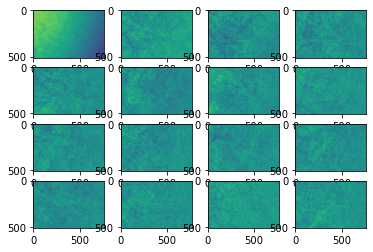

In [66]:
#Plotting the components next to eachother
fig, axs = plt.subplots(4,4)
#axs[0,0].imshow(thresholded_ipca.mean_.reshape(512,768))
#for i in range(15):
#    axs[np.floor_divide((i+1),4),np.mod((i+1),4)].imshow(thresholded_ipca.components_[i].reshape(512,768))
axs[0,0].imshow(pca.mean_.reshape(512,768))
for i in range(15):
    axs[np.floor_divide((i+1),4),np.mod((i+1),4)].imshow(pca.components_[i].reshape(512,768))
plt.savefig('PCA components.svg', dpi = 500)

In [19]:
plt.savefig('PCA components for poster.svg', dpi = 500)

<Figure size 432x288 with 0 Axes>

In [87]:
nmf_model = NMF(n_components = 15, init='random', random_state = 0, max_iter = 1000)
nmf_fitted = nmf_model.fit_transform(ims_downscaled_array)
nmf_components = nmf_model.components_

C:\Users\rwfbl\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [235]:
thresholded_ipca.mean_

array([70.93854776, 71.28259909, 71.08956635, ..., 70.94344684,
       71.03426735, 70.88713267])

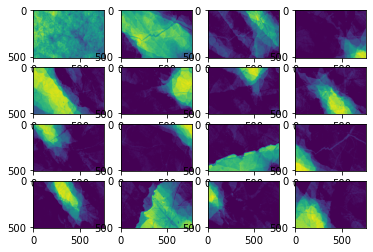

In [88]:
fig, axs = plt.subplots(4,4)
axs[0,0].imshow(ipca.mean_.reshape(512,768))
for i in range(15):
    axs[np.floor_divide((i+1),4),np.mod((i+1),4)].imshow(nmf_components[i].reshape(512,768))
plt.savefig('NMF components for Jmac to see.png', dpi = 500)

In [125]:
plt.imshow((ipca.mean_.reshape(512,768)))
ipca_tiffs[0]

AttributeError: 'float' object has no attribute 'reshape'

In [124]:
for i in range(len(ipca_tiffs)):
    ipca_tiffs[i][0] = 0
    ipca_tiffs[i][1] = 0
    ipca_tiffs[i][2] = 0
    ipca_tiffs[i][3] = 0
component_stripped = ipca.inverse_transform(ipca_tiffs)
plt.imshow(component_stripped[15].reshape(512,768))
to_save = Image.fromarray(component_stripped[15].reshape(512,768))
to_save.save('four_comps_removed_example_pca.png')

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [122]:
for i in range(len(nmf_fitted)):
    nmf_fitted[i][0] = 0
    nmf_fitted[i][1] = 0
    nmf_fitted[i][2] = 0
    nmf_fitted[i][3] = 0
component_stripped = NMF.inverse_transform(nmf_model, W=nmf_fitted)
plt.imshow(component_stripped[15].reshape(512,768))

MemoryError: Unable to allocate 627. MiB for an array with shape (209, 393216) and data type float64

In [51]:


#test = Image.fromarray(ims_downscaled_array[101].reshape(512,768)-ipca.mean_.reshape(512,768))
#plt.imshow(test)

In [52]:
#plt.imshow(ims_downscaled_array[101].reshape(512,768))

In [53]:
#test.save('test.tif')

In [162]:
processed_tifs = []
for i in range(vertical_number):
    for j in range(horizontal_number):
        print(i+1,j+1)
        pos_in_list = (horizontal_number*i)+j
        #brightness_scale_factor = np.mean(ims_downscaled_array[pos_in_list])/np.mean(ims_downscaled_array[pos_in_list]-ipca.mean_)
        #print(brightness_scale_factor)
        #to_save = Image.fromarray(ims_downscaled_array[pos_in_list].reshape(512,768)-ipca.mean_.reshape(512,768))
        mean_subtracted = ims_downscaled_array[pos_in_list]-ipca.mean_
        non_zero_black_count = np.count_nonzero(ims_downscaled_array[pos_in_list] < 15) #Count the number of pixels which are essentially black
        below_cutoff = []
        for l in range(len(ims_downscaled[pos_in_list])):
            if ims_downscaled[pos_in_list][l]<15:
                below_cutoff.append(ims_downscaled[pos_in_list][l])
        if len(below_cutoff)>3000:
            mean_of_the_zeros = np.mean(below_cutoff)
        else:
            mean_of_the_zeros = 10
        
        zero_black_count = len(ims_downscaled_array[pos_in_list])-np.count_nonzero(ims_downscaled_array[pos_in_list])
        black_count = non_zero_black_count + zero_black_count
        
        #print(black_count)
        for k in np.arange(-60,255,1):
            if k <= 0:
                mean_subtracted_black_pixels = np.count_nonzero(mean_subtracted < k)
            if k > 0:
                mean_subtracted_black_pixels = np.count_nonzero(mean_subtracted < k) + len(mean_subtracted)-np.count_nonzero(mean_subtracted)
            if mean_subtracted_black_pixels > black_count:
                threshold = k-1
                break
        print(threshold)
        
        mean_subtracted[mean_subtracted<threshold] = threshold #replace elements below the threshold with the threshold
        
        #at this point there should be as many threshold values in the processed image as there were zeroes in the original
        
        #Bear in mind that the mean of a "totally black" initial tile is actually still about 10,
        #so I should probably make zero brightness pixels actually 10s to avoid inflating the scale factor
       
        mean_subtracted_zeroed = mean_subtracted - threshold
        
        #Now there should be as many pixels of value 0 as there were pixels of < 15 initially
        
        mean_subtracted_zeroed_mean = np.mean(mean_subtracted_zeroed)
        original_mean = np.mean(ims_downscaled_array[pos_in_list])
        scale_factor = (original_mean-mean_of_the_zeros)/mean_subtracted_zeroed_mean #the 10 is to cope with that essentially being the zero value
        mean_subtracted_zeroed_scaled = (mean_subtracted_zeroed*scale_factor)+mean_of_the_zeros 
    
        #this should result in an image with a lowest value of approximately 10 and the same mean brightness as its original
        
        mean_subtracted_zeroed_scaled[mean_subtracted_zeroed_scaled>255] = 255
        mean_subtracted_zeroed_scaled = mean_subtracted_zeroed_scaled*256
        
        to_save = mean_subtracted_zeroed_scaled.reshape(512,768)
        #non_zero_black_count_check = np.count_nonzero(mean_subtracted_zeroed < 11)
        #print(non_zero_black_count)
        #print(non_zero_black_count_check)
        to_save = to_save.astype(np.uint16)
        to_save = Image.fromarray(to_save)
        if i>=9 and j>=9:
            thing = 1
            to_save.save('degridded_downscaled_'+str(i+1)+'_'+str(j+1)+'.png')
        elif i<9 and j<9:
            thing = 1
            to_save.save('degridded_downscaled_0'+str(i+1)+'_0'+str(j+1)+'.png')
        elif i<9:
            thing = 1
            to_save.save('degridded_downscaled_0'+str(i+1)+'_'+str(j+1)+'.png')
        elif j <9:
            thing = 1
            to_save.save('degridded_downscaled_'+str(i+1)+'_0'+str(j+1)+'.png')
        processed_tifs.append(to_save)

1 1
-47
1 2
-47
1 3
-48
1 4
-47
1 5
-47
1 6
-47
1 7
-47
1 8
-47
1 9
-47
1 10
-47
1 11
-47
2 1
-47
2 2
-48
2 3
-46
2 4
-44
2 5
57
2 6
-47
2 7
-47
2 8
-47
2 9
-47
2 10
-47
2 11
-47
3 1
-48
3 2
-49
3 3
-47
3 4
-42
3 5
-35
3 6
-47
3 7
-47
3 8
-47
3 9
-47
3 10
-47
3 11
-47
4 1
-48
4 2
-36
4 3
-47
4 4
-48
4 5
-45
4 6
-47
4 7
-47
4 8
-47
4 9
-47
4 10
-47
4 11
-47
5 1
-48
5 2
-46
5 3
-46
5 4
-47
5 5
-45
5 6
-48
5 7
-47
5 8
-47
5 9
-47
5 10
-47
5 11
-47
6 1
-47
6 2
-48
6 3
-47
6 4
-47
6 5
-46
6 6
-48
6 7
-47
6 8
-47
6 9
-47
6 10
-47
6 11
-47
7 1
-47
7 2
-48
7 3
-48
7 4
-48
7 5
-47
7 6
-45
7 7
-47
7 8
-47
7 9
-47
7 10
-47
7 11
-47
8 1
-47
8 2
-48
8 3
-47
8 4
-46
8 5
-49
8 6
-47
8 7
-46
8 8
-47
8 9
-47
8 10
-47
8 11
-47
9 1
-47
9 2
-48
9 3
-47
9 4
-48
9 5
-45
9 6
-49
9 7
-47
9 8
-48
9 9
-47
9 10
-47
9 11
-47
10 1
-47
10 2
-48
10 3
-47
10 4
-46
10 5
-46
10 6
-44
10 7
-47
10 8
-45
10 9
-48
10 10
-47
10 11
-47
11 1
-47
11 2
-47
11 3
-48
11 4
-46
11 5
-46
11 6
-47
11 7
-48
11 8
-47
11 9
-46
11 10
-47

In [56]:
ipca.mean_

array([80.77411265, 80.72357253, 80.77334105, ..., 79.15393519,
       78.8908179 , 78.82310957])

In [11]:
components_to_remove = 4
more_processed_tifs = []
for i in range(vertical_number):
    for j in range(horizontal_number):
        print(i+1,j+1)
        pos_in_list = (horizontal_number*i)+j
        #brightness_scale_factor = np.mean(ims_downscaled_array[pos_in_list])/np.mean(ims_downscaled_array[pos_in_list]-ipca.mean_)
        #print(brightness_scale_factor)
        #to_save = Image.fromarray(ims_downscaled_array[pos_in_list].reshape(512,768)-ipca.mean_.reshape(512,768))
        mean_subtracted = ims_downscaled_array[pos_in_list]-ipca.mean_
        for m in range(components_to_remove):
            component_subtracted = mean_subtracted - (ipca_tiffs[pos_in_list][m]*ipca.components_[m])
        mean_subtracted = component_subtracted
        
        
        
        non_zero_black_count = np.count_nonzero(ims_downscaled_array[pos_in_list] < 15) #Count the number of pixels which are essentially black
        below_cutoff = []
        for l in range(len(ims_downscaled[pos_in_list])):
            if ims_downscaled[pos_in_list][l]<15:
                below_cutoff.append(ims_downscaled[pos_in_list][l])
        if len(below_cutoff)>3000:
            mean_of_the_zeros = np.mean(below_cutoff)
        else:
            mean_of_the_zeros = 10
        
        zero_black_count = len(ims_downscaled_array[pos_in_list])-np.count_nonzero(ims_downscaled_array[pos_in_list])
        black_count = non_zero_black_count + zero_black_count
        
        #print(black_count)
        for k in np.arange(-60,255,1):
            if k <= 0:
                mean_subtracted_black_pixels = np.count_nonzero(mean_subtracted < k)
            if k > 0:
                mean_subtracted_black_pixels = np.count_nonzero(mean_subtracted < k) + len(mean_subtracted)-np.count_nonzero(mean_subtracted)
            if mean_subtracted_black_pixels > black_count:
                threshold = k-1
                break
        print(threshold)
        
        mean_subtracted[mean_subtracted<threshold] = threshold #replace elements below the threshold with the threshold
        
        #at this point there should be as many threshold values in the processed image as there were zeroes in the original
        
        #Bear in mind that the mean of a "totally black" initial tile is actually still about 10,
        #so I should probably make zero brightness pixels actually 10s to avoid inflating the scale factor
       
        mean_subtracted_zeroed = mean_subtracted - threshold
        
        #Now there should be as many pixels of value 0 as there were pixels of < 15 initially
        
        mean_subtracted_zeroed_mean = np.mean(mean_subtracted_zeroed)
        original_mean = np.mean(ims_downscaled_array[pos_in_list])
        scale_factor = (original_mean-mean_of_the_zeros)/mean_subtracted_zeroed_mean #the 10 is to cope with that essentially being the zero value
        mean_subtracted_zeroed_scaled = (mean_subtracted_zeroed*scale_factor)+mean_of_the_zeros 
    
        #this should result in an image with a lowest value of approximately 10 and the same mean brightness as its original
        
        mean_subtracted_zeroed_scaled[mean_subtracted_zeroed_scaled>255] = 255
        mean_subtracted_zeroed_scaled = mean_subtracted_zeroed_scaled*256
        
        to_save = mean_subtracted_zeroed_scaled.reshape(512,768)
        #non_zero_black_count_check = np.count_nonzero(mean_subtracted_zeroed < 11)
        #print(non_zero_black_count)
        #print(non_zero_black_count_check)
        to_save = to_save.astype(np.uint16)
        to_save = Image.fromarray(to_save)
        if i>=9 and j>=9:
            thing = 1
            to_save.save('degridded_downscaled_'+str(i+1)+'_'+str(j+1)+'.png')
        elif i<9 and j<9:
            thing = 1
            to_save.save('degridded_downscaled_0'+str(i+1)+'_0'+str(j+1)+'.png')
        elif i<9:
            thing = 1
            to_save.save('degridded_downscaled_0'+str(i+1)+'_'+str(j+1)+'.png')
        elif j <9:
            thing = 1
            to_save.save('degridded_downscaled_'+str(i+1)+'_0'+str(j+1)+'.png')
        more_processed_tifs.append(to_save)

1 1
-46
1 2
-43
1 3
-37
1 4
-38
1 5
-42
1 6
-46
1 7
-46
1 8
-46
1 9
-46
1 10
-46
1 11
-46
2 1
-46
2 2
-41
2 3
-45
2 4
-45
2 5
-24
2 6
-25
2 7
-46
2 8
-46
2 9
-46
2 10
-46
2 11
-46
3 1
-47
3 2
-48
3 3
-48
3 4
-41
3 5
-33
3 6
-45
3 7
-46
3 8
-46
3 9
-46
3 10
-46
3 11
-46
4 1
-34
4 2
-35
4 3
-47
4 4
-49
4 5
-43
4 6
-41
4 7
-19
4 8
-46
4 9
-46
4 10
-46
4 11
-46
5 1
-22
5 2
-45
5 3
-47
5 4
-49
5 5
-45
5 6
-48
5 7
-26
5 8
-46
5 9
-46
5 10
-46
5 11
-46
6 1
-32
6 2
-25
6 3
-45
6 4
-49
6 5
-47
6 6
-49
6 7
-25
6 8
-46
6 9
-46
6 10
-46
6 11
-46
7 1
-46
7 2
-37
7 3
-48
7 4
-46
7 5
-47
7 6
-43
7 7
-45
7 8
-24
7 9
-46
7 10
-46
7 11
-46
8 1
-46
8 2
-31
8 3
-46
8 4
-46
8 5
-48
8 6
-47
8 7
-47
8 8
-18
8 9
-46
8 10
-46
8 11
-46
9 1
-46
9 2
-27
9 3
-47
9 4
-48
9 5
-45
9 6
-50
9 7
-48
9 8
-45
9 9
-19
9 10
-47
9 11
-46
10 1
-46
10 2
-18
10 3
-47
10 4
-46
10 5
-46
10 6
-44
10 7
-47
10 8
-45
10 9
-47
10 10
-42
10 11
-46
11 1
-46
11 2
-47
11 3
-18
11 4
-46
11 5
-46
11 6
-46
11 7
-48
11 8
-46
11 9
-46
11 10
-3

In [248]:
more_processed_tifs

[]

In [297]:
components_to_remove = 4
even_more_processed_tifs = []
for i in range(vertical_number):
    for j in range(horizontal_number):
        print(i+1,j+1)
        pos_in_list = (horizontal_number*i)+j
        #brightness_scale_factor = np.mean(ims_downscaled_array[pos_in_list])/np.mean(ims_downscaled_array[pos_in_list]-ipca.mean_)
        #print(brightness_scale_factor)
        #to_save = Image.fromarray(ims_downscaled_array[pos_in_list].reshape(512,768)-ipca.mean_.reshape(512,768))
        mean_subtracted = ims_downscaled_array_copy[pos_in_list]-thresholded_ipca.mean_
        for m in range(components_to_remove):
            component_subtracted = mean_subtracted - (thresholded_ipca_tifs[pos_in_list][m]*thresholded_ipca.components_[m])
        mean_subtracted = component_subtracted
        
        
        
        non_zero_black_count = np.count_nonzero(ims_downscaled_array_copy[pos_in_list] < 15) #Count the number of pixels which are essentially black
        below_cutoff = []
        for l in range(len(ims_downscaled_array_copy[pos_in_list])):
            if ims_downscaled[pos_in_list][l]<15:
                below_cutoff.append(ims_downscaled[pos_in_list][l])
        if len(below_cutoff)>3000:
            mean_of_the_zeros = np.mean(below_cutoff)
        else:
            mean_of_the_zeros = 10
        
        zero_black_count = len(ims_downscaled_array_copy[pos_in_list])-np.count_nonzero(ims_downscaled_array[pos_in_list])
        black_count = non_zero_black_count + zero_black_count
        
        #print(black_count)
        for k in np.arange(-60,255,1):
            if k <= 0:
                mean_subtracted_black_pixels = np.count_nonzero(mean_subtracted < k)
            if k > 0:
                mean_subtracted_black_pixels = np.count_nonzero(mean_subtracted < k) + len(mean_subtracted)-np.count_nonzero(mean_subtracted)
            if mean_subtracted_black_pixels > black_count:
                threshold = k-1
                break
        print(threshold)
        
        mean_subtracted[mean_subtracted<threshold] = threshold #replace elements below the threshold with the threshold
        
        #at this point there should be as many threshold values in the processed image as there were zeroes in the original
        
        #Bear in mind that the mean of a "totally black" initial tile is actually still about 10,
        #so I should probably make zero brightness pixels actually 10s to avoid inflating the scale factor
       
        mean_subtracted_zeroed = mean_subtracted - threshold
        
        #Now there should be as many pixels of value 0 as there were pixels of < 15 initially
        
        mean_subtracted_zeroed_mean = np.mean(mean_subtracted_zeroed)
        original_mean = np.mean(ims_downscaled_array[pos_in_list])
        scale_factor = (original_mean-mean_of_the_zeros)/mean_subtracted_zeroed_mean
        mean_subtracted_zeroed_scaled = (mean_subtracted_zeroed*scale_factor)+mean_of_the_zeros 
    
        #this should result in an image with a lowest value of approximately 10 and the same mean brightness as its original
        
        mean_subtracted_zeroed_scaled[mean_subtracted_zeroed_scaled>255] = 255
        mean_subtracted_zeroed_scaled = mean_subtracted_zeroed_scaled*256
        
        to_save = mean_subtracted_zeroed_scaled.reshape(512,768)
        #non_zero_black_count_check = np.count_nonzero(mean_subtracted_zeroed < 11)
        #print(non_zero_black_count)
        #print(non_zero_black_count_check)
        #to_save = to_save.astype(np.uint16)
        #to_save = Image.fromarray(to_save)
        if i>=9 and j>=9:
            thing = 1
            #to_save.save('degridded_downscaled_'+str(i+1)+'_'+str(j+1)+'.png')
        elif i<9 and j<9:
            thing = 1
            #to_save.save('degridded_downscaled_0'+str(i+1)+'_0'+str(j+1)+'.png')
        elif i<9:
            thing = 1
            #to_save.save('degridded_downscaled_0'+str(i+1)+'_'+str(j+1)+'.png')
        elif j <9:
            thing = 1
            #to_save.save('degridded_downscaled_'+str(i+1)+'_0'+str(j+1)+'.png')
        even_more_processed_tifs.append(to_save)

1 1
-3
1 2
-3
1 3
-3
1 4
-34
1 5
-6
1 6
-3
1 7
-3
1 8
-3
1 9
-3
1 10
-3
1 11
-3
2 1
-3
2 2
-3
2 3
-3
2 4
-3
2 5
-3
2 6
-9
2 7
-3
2 8
-3
2 9
-3
2 10
-3
2 11
-3
3 1
-3
3 2
-4
3 3
-3
3 4
-3
3 5
-3
3 6
-10
3 7
-3
3 8
-3
3 9
-3
3 10
-3
3 11
-3
4 1
-3
4 2
-3
4 3
-3
4 4
-3
4 5
-3
4 6
-3
4 7
-8
4 8
-3
4 9
-3
4 10
-3
4 11
-3
5 1
-3
5 2
-3
5 3
-3
5 4
-3
5 5
-3
5 6
-3
5 7
-7
5 8
-3
5 9
-3
5 10
-3
5 11
-3
6 1
-3
6 2
-4
6 3
-3
6 4
-3
6 5
-3
6 6
-4
6 7
-9
6 8
-3
6 9
-3
6 10
-3
6 11
-3
7 1
-3
7 2
-4
7 3
-3
7 4
-3
7 5
-3
7 6
-3
7 7
-3
7 8
-9
7 9
-3
7 10
-3
7 11
-3
8 1
-3
8 2
-4
8 3
-3
8 4
-3
8 5
-4
8 6
-3
8 7
-3
8 8
-19
8 9
-3
8 10
-3
8 11
-3
9 1
-3
9 2
-4
9 3
-3
9 4
-3
9 5
-4
9 6
-3
9 7
-3
9 8
-3
9 9
-10
9 10
-3
9 11
-3
10 1
-3
10 2
-4
10 3
-3
10 4
-3
10 5
-3
10 6
-3
10 7
-4
10 8
-3
10 9
-3
10 10
-13
10 11
-3
11 1
-3
11 2
-3
11 3
-4
11 4
-3
11 5
-3
11 6
-3
11 7
-3
11 8
-6
11 9
-3
11 10
-3
11 11
-6
12 1
-3
12 2
-3
12 3
-3
12 4
-3
12 5
-3
12 6
-3
12 7
-15
12 8
-3
12 9
-3
12 10
-3
12 11
-8
13 1
-3
13 2


In [300]:
#even_more_processed_tifs_array = []
#for i in range(len(even_more_processed_tifs)):
#    thing = 1
#    even_more_processed_tifs_array.append(even_more_processed_tifs[i].flatten())
#even_more_processed_tifs_array[i]

array([31320.57458663, 28360.52000977, 30658.59269537, ...,
       40057.00112354, 38010.1283163 , 41014.08890961])

In [11]:
processed_direct_import = [plt.imread(path) for path in glob.glob("Processed pngs/*.png")]
np.array(processed_direct_import)


array([[[0.47780576, 0.4324712 , 0.46755168, ..., 0.59008163,
         0.62534523, 0.6324407 ],
        [0.35259023, 0.35326162, 0.3881285 , ..., 0.59693295,
         0.6170901 , 0.577966  ],
        [0.34505227, 0.38760966, 0.39081407, ..., 0.60622567,
         0.6122988 , 0.5569238 ],
        ...,
        [0.42322424, 0.39822996, 0.41245136, ..., 0.60028994,
         0.5895018 , 0.5941558 ],
        [0.43341726, 0.44078737, 0.45423058, ..., 0.57605857,
         0.5982452 , 0.6002289 ],
        [0.45653468, 0.45975432, 0.39726862, ..., 0.61103225,
         0.57930875, 0.6261387 ]],

       [[0.45304036, 0.41029984, 0.4440833 , ..., 0.56015867,
         0.5920348 , 0.5988861 ],
        [0.33421835, 0.33522546, 0.3689479 , ..., 0.5651484 ,
         0.584329  , 0.5482719 ],
        [0.32738233, 0.36855116, 0.37033647, ..., 0.5741207 ,
         0.57964444, 0.5267872 ],
        ...,
        [0.4029755 , 0.3794003 , 0.392813  , ..., 0.9008164 ,
         0.688426  , 0.5656367 ],
        [0.4

In [31]:
even_more_processed_tifs_array = []
for i in range(len(processed_direct_import)):
    thing = 1
    even_more_processed_tifs_array.append(processed_direct_import[i].flatten())
even_more_processed_tifs_array[i]

array([0.47791258, 0.43274587, 0.4678111 , ..., 0.6112306 , 0.5799954 ,
       0.6258335 ], dtype=float32)

In [14]:
double_ipca = IncrementalPCA(n_components=15, batch_size=horizontal_number*vertical_number)
double_ipca_tiffs = double_ipca.fit_transform(even_more_processed_tifs_array)

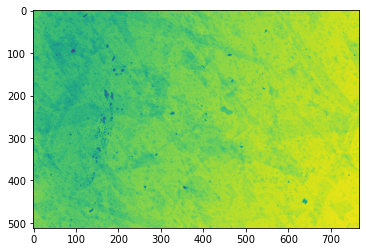

In [16]:
plt.imshow(double_ipca.mean_.reshape(512,768))

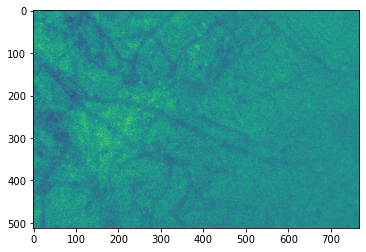

In [53]:
plt.imshow(double_ipca.components_[7].reshape(512,768))

(209, 512, 768)

In [54]:
components_to_remove = 1
double_processed_tifs = []
for i in range(vertical_number):
    for j in range(horizontal_number):
        print(i+1,j+1)
        pos_in_list = (horizontal_number*i)+j
        #brightness_scale_factor = np.mean(ims_downscaled_array[pos_in_list])/np.mean(ims_downscaled_array[pos_in_list]-ipca.mean_)
        #print(brightness_scale_factor)
        #to_save = Image.fromarray(ims_downscaled_array[pos_in_list].reshape(512,768)-ipca.mean_.reshape(512,768))
        mean_subtracted = even_more_processed_tifs_array[pos_in_list]-double_ipca.mean_
        non_zero_black_count = np.count_nonzero(even_more_processed_tifs_array[pos_in_list] < 15) #Count the number of pixels which are essentially black
        below_cutoff = []
        for l in range(len(even_more_processed_tifs_array[pos_in_list])):
            if even_more_processed_tifs_array[pos_in_list][l]<15:
                below_cutoff.append(even_more_processed_tifs_array[pos_in_list][l])
        if len(below_cutoff)>3000:
            mean_of_the_zeros = np.mean(below_cutoff)
        else:
            mean_of_the_zeros = 10
            
            
        for m in range(components_to_remove):
            component_subtracted = mean_subtracted - (double_ipca_tiffs[pos_in_list][m]*double_ipca.components_[m])
        mean_subtracted = component_subtracted
        
        zero_black_count = len(even_more_processed_tifs_array[pos_in_list])-np.count_nonzero(even_more_processed_tifs_array[pos_in_list])
        black_count = non_zero_black_count + zero_black_count
        
        #print(black_count)
        for k in np.arange(-60,255,1):
            if k <= 0:
                mean_subtracted_black_pixels = np.count_nonzero(mean_subtracted < k)
            if k > 0:
                mean_subtracted_black_pixels = np.count_nonzero(mean_subtracted < k) + len(mean_subtracted)-np.count_nonzero(mean_subtracted)
            if mean_subtracted_black_pixels > black_count:
                threshold = k-1
            else:
                threshold = 10
                break
        print(threshold)
        
        mean_subtracted[mean_subtracted<threshold] = threshold #replace elements below the threshold with the threshold
        
        #at this point there should be as many threshold values in the processed image as there were zeroes in the original
        
        #Bear in mind that the mean of a "totally black" initial tile is actually still about 10,
        #so I should probably make zero brightness pixels actually 10s to avoid inflating the scale factor
       
        mean_subtracted_zeroed = mean_subtracted - threshold
        
        #Now there should be as many pixels of value 0 as there were pixels of < 15 initially
        
        mean_subtracted_zeroed_mean = np.mean(mean_subtracted_zeroed)
        original_mean = np.mean(ims_downscaled_array[pos_in_list])
        scale_factor = (original_mean-mean_of_the_zeros)/mean_subtracted_zeroed_mean #the 10 is to cope with that essentially being the zero value
        mean_subtracted_zeroed_scaled = (mean_subtracted_zeroed*scale_factor)+mean_of_the_zeros 
    
        #this should result in an image with a lowest value of approximately 10 and the same mean brightness as its original
        
        mean_subtracted_zeroed_scaled[mean_subtracted_zeroed_scaled>255] = 255
        mean_subtracted_zeroed_scaled = mean_subtracted_zeroed_scaled*256
        
        to_save = mean_subtracted_zeroed_scaled.reshape(512,768)
        #non_zero_black_count_check = np.count_nonzero(mean_subtracted_zeroed < 11)
        #print(non_zero_black_count)
        #print(non_zero_black_count_check)
        to_save = to_save.astype(np.uint16)
        to_save = Image.fromarray(to_save)
        if i>=9 and j>=9:
            thing = 1
            to_save.save('double_degridded_downscaled_'+str(i+1)+'_'+str(j+1)+'.png')
        elif i<9 and j<9:
            thing = 1
            to_save.save('double_degridded_downscaled_0'+str(i+1)+'_0'+str(j+1)+'.png')
        elif i<9:
            thing = 1
            to_save.save('double_degridded_downscaled_0'+str(i+1)+'_'+str(j+1)+'.png')
        elif j <9:
            thing = 1
            to_save.save('double_degridded_downscaled_'+str(i+1)+'_0'+str(j+1)+'.png')
        double_processed_tifs.append(to_save)

1 1
0
1 2
0
1 3
0
1 4
0
1 5
0
1 6
0
1 7
0
1 8
0
1 9
0
1 10
0
1 11
0
2 1
0
2 2
0
2 3
0
2 4
0
2 5
0
2 6
0
2 7
0
2 8
0
2 9
0
2 10
0
2 11
0
3 1
0
3 2
0
3 3
0
3 4
0
3 5
0
3 6
0
3 7
0
3 8
0
3 9
0
3 10
0
3 11
0
4 1
0
4 2
0
4 3
0
4 4
0
4 5
0
4 6
0
4 7
0
4 8
0
4 9
0
4 10
0
4 11
0
5 1
0
5 2
0
5 3
0
5 4
0
5 5
0
5 6
0
5 7
0
5 8
0
5 9
0
5 10
0
5 11
0
6 1
0
6 2
0
6 3
0
6 4
0
6 5
0
6 6
0
6 7
0
6 8
0
6 9
0
6 10
0
6 11
0
7 1
0
7 2
0
7 3
0
7 4
0
7 5
0
7 6
0
7 7
0
7 8
0
7 9
0
7 10
0
7 11
0
8 1
0
8 2
0
8 3
0
8 4
0
8 5
0
8 6
0
8 7
0
8 8
0
8 9
0
8 10
0
8 11
0
9 1
0
9 2
0
9 3
0
9 4
0
9 5
0
9 6
0
9 7
0
9 8
0
9 9
0
9 10
0
9 11
0
10 1
0
10 2
0
10 3
0
10 4
0
10 5
0
10 6
0
10 7
0
10 8
0
10 9
0
10 10
0
10 11
0
11 1
0
11 2
0
11 3
0
11 4
0
11 5
0
11 6
0
11 7
0
11 8
0
11 9
0
11 10
0
11 11
0
12 1
0
12 2
0
12 3
0
12 4
0
12 5
0
12 6
0
12 7
0
12 8
0
12 9
0
12 10
0
12 11
0
13 1
0
13 2
0
13 3
0
13 4
0
13 5
0
13 6
0
13 7
0
13 8
0
13 9
0
13 10
0
13 11
0
14 1
0
14 2
0
14 3
0
14 4
0
14 5
0
14 6
0
14 7
0
14 8
0
14 9
0
14 10
0
1